In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler, label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [9]:
# Definícia datasetu pre model SalesPerformDataset
class SalesPerformDataset(Dataset):
    # Inicializácia datasetu prijímajúca vstupy a cieľové hodnoty
    def __init__(self, X_train, y_test):
        # Konverzia vstupných a cieľových hodnôt na PyTorch tenzory typu FloatTensor
        self.X_train_tensor = torch.FloatTensor(X_train)
        self.y_test_tensor = torch.FloatTensor(y_test)

    # Vracia dĺžku datasetu (počet záznamov)
    def __len__(self):
        return len(self.X_train_tensor)

    # Umožňuje prístup k jednotlivým prvkom datasetu pomocou indexu
    def __getitem__(self, idx):
        return self.X_train_tensor[idx], self.y_test_tensor[idx]


# Definícia neurónovej siete SalesPerformNN pre klasifikáciu predajného výkonu
class SalesPerformNN(nn.Module):
    # Inicializácia modelu s definovaním vrstiev
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout1, dropout2):
        super(SalesPerformNN, self).__init__()
        
        # Definovanie vstupnej vrstvy (input_size -> hidden_size1)
        self.input_layer = nn.Linear(input_size, hidden_size1)
        
        # Prvá skrytá vrstva (hidden_size1 -> hidden_size2)
        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        # Batch normalizácia po prvej skrytej vrstve
        self.batch_norm1 = nn.BatchNorm1d(hidden_size2)
        # Dropout na prevenciu overfittingu
        self.dropout1 = nn.Dropout(dropout1)
        
        # Druhá skrytá vrstva (hidden_size2 -> hidden_size3)
        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        # Batch normalizácia po druhej skrytej vrstve
        self.batch_norm2 = nn.BatchNorm1d(hidden_size3)
        # Ďalší dropout
        self.dropout2 = nn.Dropout(dropout2)

        # Výstupná vrstva (hidden_size3 -> output_size), používa sa pre binárnu klasifikáciu
        self.output_layer = nn.Linear(hidden_size3, output_size)

    # Definovanie forward prechodu modelu
    def forward(self, x):
        # Aplikovanie vstupnej vrstvy a ReLU aktivačnej funkcie
        x = torch.relu(self.input_layer(x))

        # Prvá skrytá vrstva s ReLU, batch normalizáciou a dropoutom
        x = torch.relu(self.batch_norm1(self.hidden_layer1(x)))
        x = self.dropout1(x)

        # Druhá skrytá vrstva s ReLU, batch normalizáciou a dropoutom
        x = torch.relu(self.batch_norm2(self.hidden_layer2(x)))
        x = self.dropout2(x)

        # Výstupná vrstva, výstup bez aktivácie (logits pre BCEWithLogitsLoss)
        x = self.output_layer(x)

        return x


# Funkcia na výpočet metrík (presnosť, presnosť (precision), citlivosť (recall), F1 skóre)
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1
    

# Funkcia na tréning modelu
def train(model, train_loader, criterion, optimizer, device):
    # Nastavenie modelu do režimu tréningu
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Prechádzanie cez tréningové dáta
    for inputs, labels in train_loader:
        # Presun dát na GPU, ak je dostupná
        inputs, labels = inputs.to(device), labels.to(device)
        # Vymazanie gradientov
        optimizer.zero_grad()
        
        # Výpočet výstupov modelu
        outputs = model(inputs).squeeze()
        # Výpočet straty
        loss = criterion(outputs, labels.float())
        
        # Backpropagation - výpočet gradientov
        loss.backward()
        # Optimalizácia parametrov modelu
        optimizer.step()
        
        # Akumulácia tréningovej straty
        running_loss += loss.item()
        # Prevod logitov na predikcie (s použitím sigmoid)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        # Uloženie predikcií a skutočných hodnôt
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Výpočet priemernej epochovej straty
    epoch_loss = running_loss / len(train_loader)
    # Výpočet metrík
    accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)
    return epoch_loss, accuracy, precision, recall, f1


# Funkcia na validáciu modelu
def validate(model, val_loader, criterion, device):
    # Nastavenie modelu do evaluačného režimu
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Zakázanie výpočtu gradientov počas validácie
    with torch.inference_mode():
        # Prechádzanie cez validačné dáta
        for inputs, labels in val_loader:
            # Presun dát na GPU, ak je dostupná
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Výpočet výstupov modelu
            outputs = model(inputs).squeeze()
            # Výpočet straty
            loss = criterion(outputs, labels.float())
            
            # Akumulácia validačnej straty
            running_loss += loss.item()
            # Prevod logitov na predikcie (s použitím sigmoid)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            # Uloženie predikcií a skutočných hodnôt
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Výpočet priemernej epochovej straty
    epoch_loss = running_loss / len(val_loader)
    # Výpočet metrík
    accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)
    return epoch_loss, accuracy, precision, recall, f1


# Funkcia na tréning a validáciu modelu s použitím schedulera
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, patience=10):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    learning_rates = []

    # Inicializácia najlepšej validačnej straty na nekonečno
    best_val_loss = float('inf')
    best_model = None
    counter = 0

    # Hlavná tréningová slučka
    for epoch in range(num_epochs):
        # Tréning modelu
        train_loss, train_acc, train_prec, train_rec, train_f1 = train(model, train_loader, criterion, optimizer, device)
        # Validácia modelu
        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, val_loader, criterion, device)
        
        # Aktualizácia schedulera na základe validačnej straty
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Ukladanie tréningových a validačných strát, metrík a learning rate
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics.append((train_acc, train_prec, train_rec, train_f1))
        val_metrics.append((val_acc, val_prec, val_rec, val_f1))
        learning_rates.append(current_lr)

        # Výpis výsledkov pre každú epochu
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f} | Precision: {train_prec:.4f} | Recall: {train_rec:.4f} | F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1: {val_f1:.4f}')
        print(f'Learning Rate: {current_lr}')
        
        # Ak validačná strata klesne, uloží sa najlepší model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            # Ak sa validačná strata nezlepšuje, zvyšuje sa counter
            counter += 1
            
         # Ak sa model nezlepšuje dlhší čas, spustí sa early stopping
        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
        
        print('-' * 50)
        
    # Obnovenie najlepšieho modelu z uloženého stavu
    model.load_state_dict(best_model)
        
    return model, train_losses, val_losses, train_metrics, val_metrics, learning_rates    



In [10]:
# Nastavenie semena pre reprodukovateľnosť výsledkov (zabezpečuje, že každý beh kódu bude mať rovnaké výsledky)
torch.manual_seed(42)

# Načítanie dát zo súboru CSV do DataFrame
df = pd.read_csv('../dataset/sales_data.csv')

# Vytvorenie a aplikovanie ordinalného enkodéra na stĺpec 'Age_Group' s preddefinovanými kategóriami
ordinal_encoder = OrdinalEncoder(categories=[['Youth (<25)', 'Young Adults (25-34)', 'Adults (35-64)', 'Seniors (64+)']])
# Pridanie nového stĺpca s enkódovanými hodnotami vekových skupín
df['Age_Group_Encoded'] = ordinal_encoder.fit_transform(df[['Age_Group']])

# Aplikovanie LabelEncoder na stĺpec 'Customer_Gender' na prevod kategórií na numerické hodnoty
df['Customer_Gender_Encoded'] = LabelEncoder().fit_transform(df['Customer_Gender'])
# Aplikovanie LabelEncoder na stĺpec 'Country' na prevod krajín na numerické hodnoty
df['Country_Encoded'] = LabelEncoder().fit_transform(df['Country'])
# Aplikovanie LabelEncoder na stĺpec 'State' na prevod štátov na numerické hodnoty
df['State_Encoded'] = LabelEncoder().fit_transform(df['State'])
# Aplikovanie LabelEncoder na stĺpec 'Product_Category' na prevod kategórií produktov na numerické hodnoty
df['Product_Category_Encoded'] = LabelEncoder().fit_transform(df['Product_Category'])
# Aplikovanie LabelEncoder na stĺpec 'Sub_Category' na prevod subkategórií produktov na numerické hodnoty
df['Sub_Category_Encoded'] = LabelEncoder().fit_transform(df['Sub_Category'])

# Výber feature stĺpcov a ich konverzia na NumPy pole
X = df[['Customer_Age', 'Age_Group_Encoded', 'Customer_Gender_Encoded', 'Country_Encoded', 'State_Encoded', 'Product_Category_Encoded', 'Sub_Category_Encoded', 'Order_Quantity', 'Unit_Cost', 'Unit_Price', 'Profit']].values

# Definovanie vektora y na základe hodnoty Revenue; nastavenie prahu na 90. percentil
threshold = df['Revenue'].quantile(0.90) 
# Vytvorenie binárnych hodnot na základe toho, či je Revenue nad alebo pod prahom (90. percentil)
y = (df['Revenue'] > threshold).astype(int).values

# Rozdelenie dát na tréningovú a testovaciu množinu (80% tréning, 20% testovanie) s nastaveným semenom pre reprodukovateľnosť
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizácia dát: fitovanie na tréningových dátach a transformácia tréningových a testovacích dát
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalizácia tréningových dát
X_test_scaled = scaler.transform(X_test)  # Normalizácia testovacích dát na rovnakú škálu

# Výpis tvaru normalizovaných tréningových dát a tvaru cieľových hodnôt
X_train_scaled.shape, y_train.shape


((90428, 11), (90428,))

In [5]:
# Vytvorenie tréningového datasetu a testovacieho datasetu
train_dataset = SalesPerformDataset(X_train_scaled, y_train)
test_dataset = SalesPerformDataset(X_test_scaled, y_test)

# Vytvorenie DataLoader pre tréningové dáta; batch_size určuje počet vzoriek na jednu dávku, shuffle=True zabezpečuje náhodné premiešanie dát
train_loader = DataLoader(train_dataset, batch_size=1056, shuffle=True)

# Vytvorenie DataLoader pre testovacie dáta; shuffle=False zabezpečuje, že dáta zostanú v pôvodnom poradí
val_loader = DataLoader(test_dataset, batch_size=1056, shuffle=False)

# Nastavenie veľkosti vstupu, skrytých vrstiev a výstupu modelu
input_size = 11  # Počet vstupných prvkov (features)
hidden_size1 = 104  # Počet neurónov v prvej skrytej vrstve
hidden_size2 = 104  # Počet neurónov v druhej skrytej vrstve
hidden_size3 = 40   # Počet neurónov v tretej skrytej vrstve
output_size = 1     # Počet výstupných neurónov (1 pre binárnu klasifikáciu)
dropout1 = 0.1     # Miera dropoutu pre prvú skrytú vrstvu
dropout2 = 0.1     # Miera dropoutu pre druhú skrytú vrstvu

# Vytvorenie modelu so zadanými parametrami
model = SalesPerformNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout1, dropout2)

# Definovanie stratovej funkcie (Binary Cross Entropy with Logits Loss) pre binárnu klasifikáciu
criterion = nn.BCEWithLogitsLoss()

# Definovanie optimalizátora (Adam) s nastaviteľnou rýchlosťou učenia a regularizáciou váh
optimizer = optim.Adam(model.parameters(), lr=0.0035, weight_decay=3e-05)

# Definovanie plánovača učenia, ktorý znižuje rýchlosť učenia, keď sa validácia strata nezlepší; patiences určuje počet epoch bez zlepšenia, kedy sa rýchlosť učenia zníži
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Nastavenie počtu epoch na tréning modelu a počet epoch pre early stopping (tranzitívny mechanizmus na ukončenie tréningu, ak sa stratová funkcia nezlepšuje)
num_epochs = 94
patience = 10

# Určenie zariadenia na tréning (GPU, ak je dostupný, inak CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tréning a validácia modelu; vracia najlepší model a metriky tréningu a validácie
model_train_val, train_losses, val_losses, train_metrics, val_metrics, learning_rates = train_and_validate(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer,
    scheduler,
    device, 
    num_epochs,
    patience
)


Epoch 1/94
Train Loss: 0.1393 | Accuracy: 0.9760 | Precision: 0.8398 | Recall: 0.9339 | F1: 0.8843
Val Loss: 0.0378 | Accuracy: 0.9920 | Precision: 0.9600 | Recall: 0.9591 | F1: 0.9595
Learning Rate: 0.0035
--------------------------------------------------
Epoch 2/94
Train Loss: 0.0257 | Accuracy: 0.9937 | Precision: 0.9677 | Recall: 0.9681 | F1: 0.9679
Val Loss: 0.0180 | Accuracy: 0.9959 | Precision: 0.9647 | Recall: 0.9946 | F1: 0.9794
Learning Rate: 0.0035
--------------------------------------------------
Epoch 3/94
Train Loss: 0.0132 | Accuracy: 0.9965 | Precision: 0.9802 | Recall: 0.9848 | F1: 0.9825
Val Loss: 0.0089 | Accuracy: 0.9964 | Precision: 0.9677 | Recall: 0.9969 | F1: 0.9821
Learning Rate: 0.0035
--------------------------------------------------
Epoch 4/94
Train Loss: 0.0094 | Accuracy: 0.9969 | Precision: 0.9820 | Recall: 0.9868 | F1: 0.9844
Val Loss: 0.0085 | Accuracy: 0.9969 | Precision: 0.9954 | Recall: 0.9735 | F1: 0.9843
Learning Rate: 0.0035
-------------------

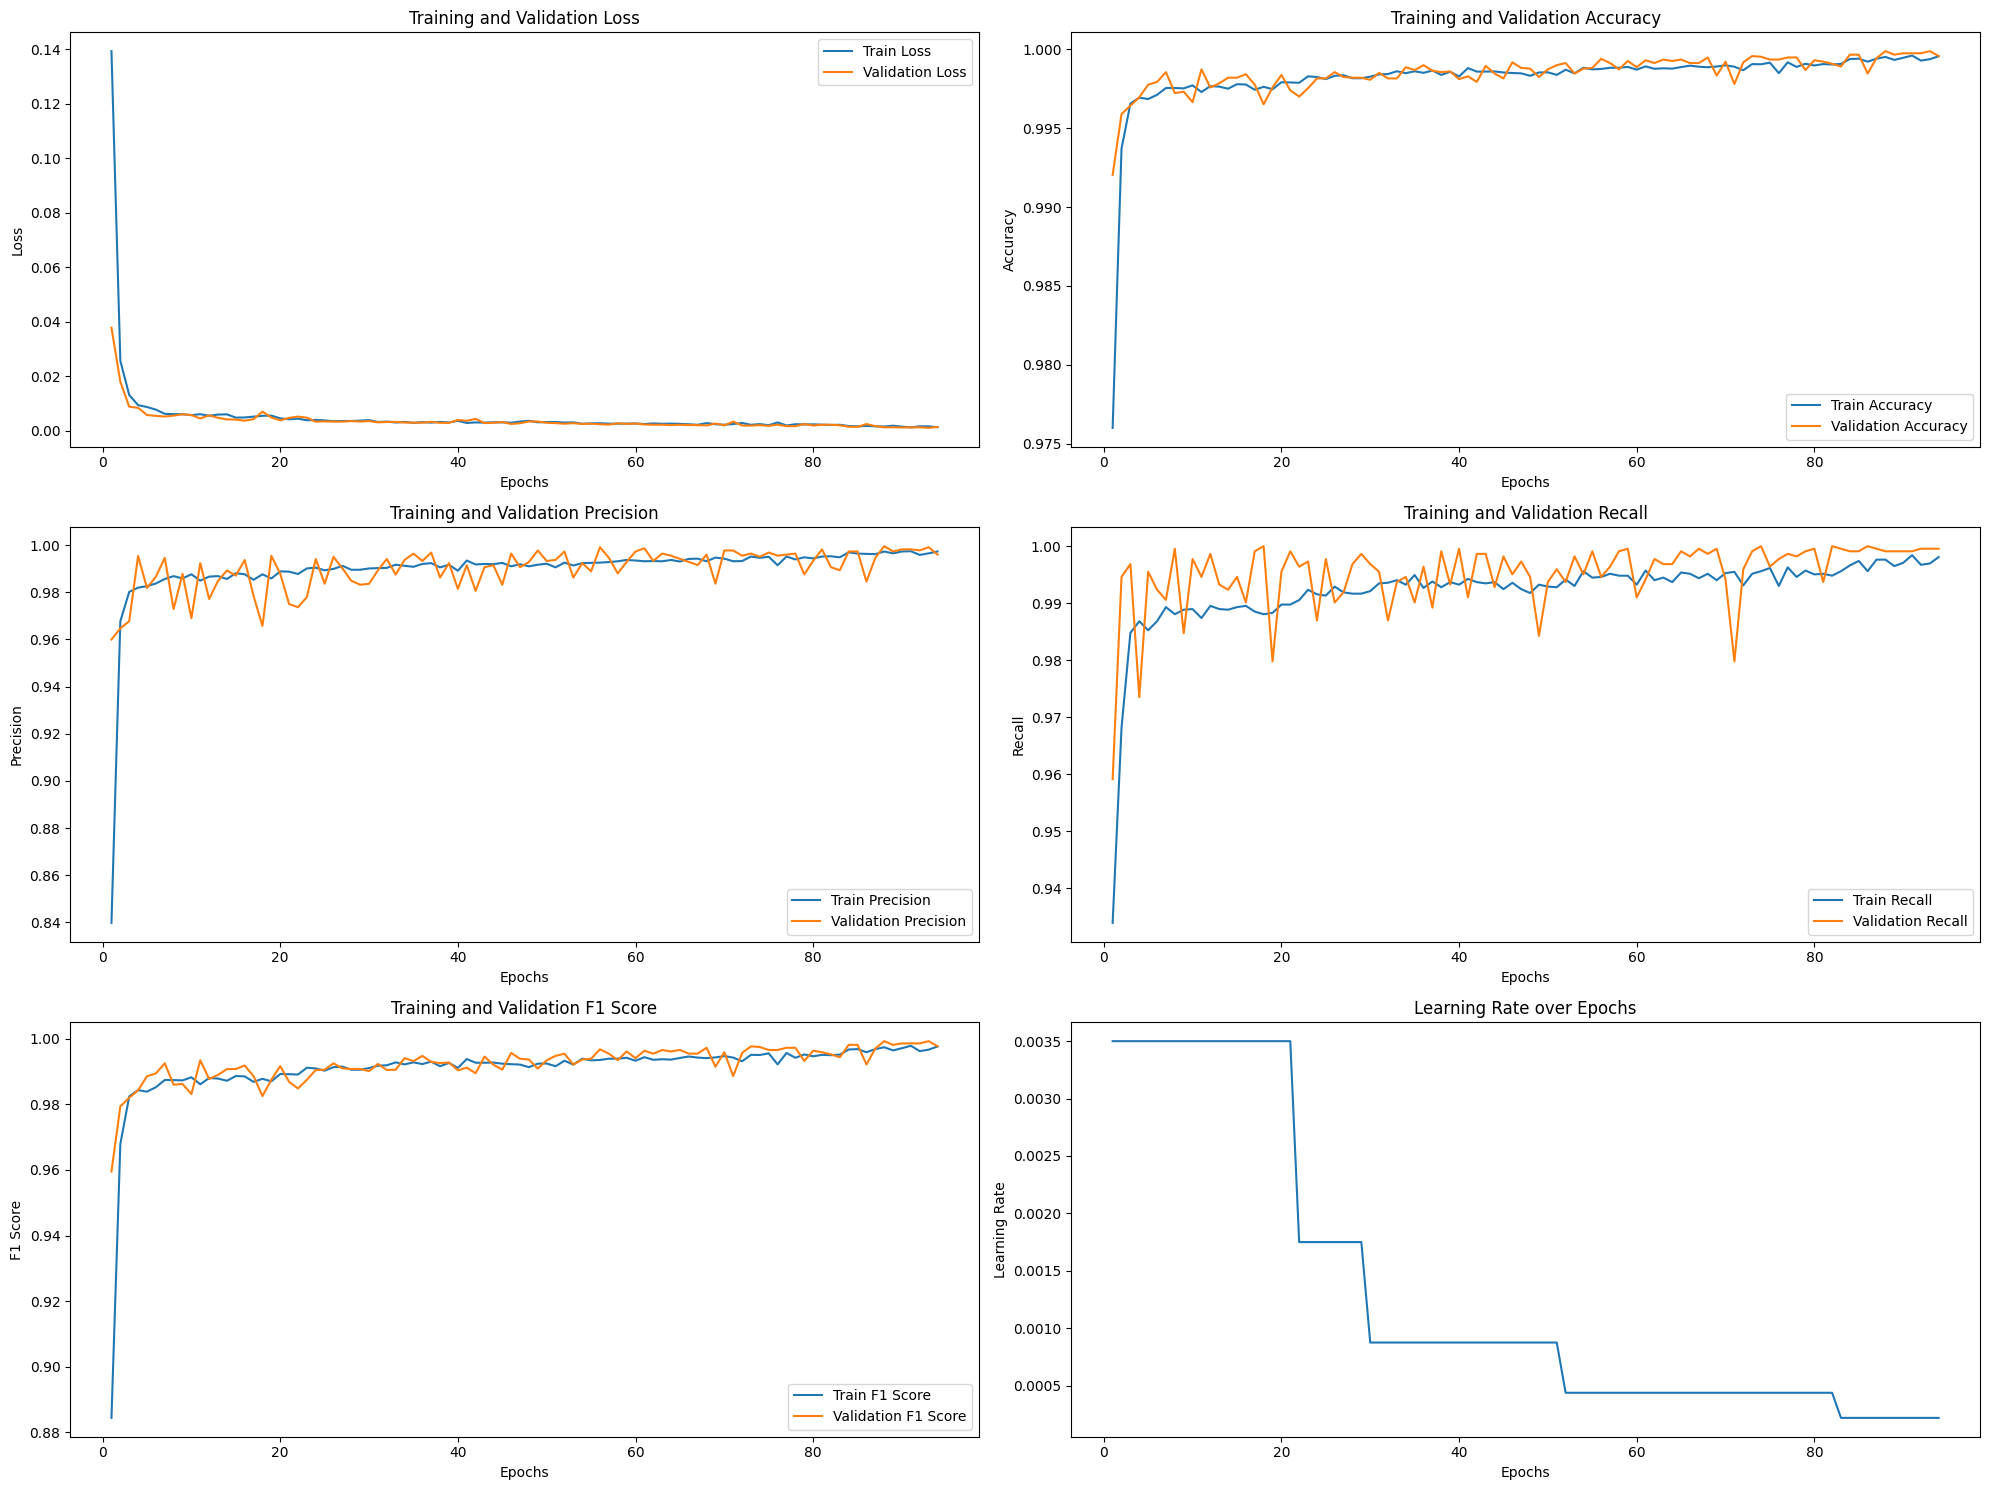

In [11]:
import matplotlib.pyplot as plt

def plot_results(train_losses, val_losses, train_metrics, val_metrics, learning_rates):
    # Generovanie rozsahu epochov pre x-ovú os grafov
    epochs = range(1, len(train_losses) + 1)
    
    # Nastavenie veľkosti grafu
    plt.figure(figsize=(20, 15))

    # Vykreslenie grafu strat
    plt.subplot(3, 2, 1)  # 3 riadky, 2 stĺpce, prvý graf
    plt.plot(epochs, train_losses, label='Train Loss')  # Vykreslenie stratového grafu pre tréning
    plt.plot(epochs, val_losses, label='Validation Loss')  # Vykreslenie stratového grafu pre validáciu
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('Loss')  # Popis y-ovej osi
    plt.title('Training and Validation Loss')  # Názov grafu
    plt.legend()  # Zobrazenie legendy

    # Vykreslenie grafu presnosti
    plt.subplot(3, 2, 2)  # 3 riadky, 2 stĺpce, druhý graf
    plt.plot(epochs, [m[0] for m in train_metrics], label='Train Accuracy')  # Vykreslenie presnosti pre tréning
    plt.plot(epochs, [m[0] for m in val_metrics], label='Validation Accuracy')  # Vykreslenie presnosti pre validáciu
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('Accuracy')  # Popis y-ovej osi
    plt.title('Training and Validation Accuracy')  # Názov grafu
    plt.legend()  # Zobrazenie legendy

    # Vykreslenie grafu presnosti
    plt.subplot(3, 2, 3)  # 3 riadky, 2 stĺpce, tretí graf
    plt.plot(epochs, [m[1] for m in train_metrics], label='Train Precision')  # Vykreslenie presnosti pre tréning
    plt.plot(epochs, [m[1] for m in val_metrics], label='Validation Precision')  # Vykreslenie presnosti pre validáciu
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('Precision')  # Popis y-ovej osi
    plt.title('Training and Validation Precision')  # Názov grafu
    plt.legend()  # Zobrazenie legendy

    # Vykreslenie grafu citlivosti (recall)
    plt.subplot(3, 2, 4)  # 3 riadky, 2 stĺpce, štvrtý graf
    plt.plot(epochs, [m[2] for m in train_metrics], label='Train Recall')  # Vykreslenie recall pre tréning
    plt.plot(epochs, [m[2] for m in val_metrics], label='Validation Recall')  # Vykreslenie recall pre validáciu
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('Recall')  # Popis y-ovej osi
    plt.title('Training and Validation Recall')  # Názov grafu
    plt.legend()  # Zobrazenie legendy

    # Vykreslenie grafu F1 skóre
    plt.subplot(3, 2, 5)  # 3 riadky, 2 stĺpce, piaty graf
    plt.plot(epochs, [m[3] for m in train_metrics], label='Train F1 Score')  # Vykreslenie F1 skóre pre tréning
    plt.plot(epochs, [m[3] for m in val_metrics], label='Validation F1 Score')  # Vykreslenie F1 skóre pre validáciu
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('F1 Score')  # Popis y-ovej osi
    plt.title('Training and Validation F1 Score')  # Názov grafu
    plt.legend()  # Zobrazenie legendy

    # Vykreslenie grafu rýchlosti učenia
    plt.subplot(3, 2, 6)  # 3 riadky, 2 stĺpce, šiesty graf
    plt.plot(epochs, learning_rates)  # Vykreslenie grafu rýchlosti učenia
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('Learning Rate')  # Popis y-ovej osi
    plt.title('Learning Rate over Epochs')  # Názov grafu

    # Uloženie grafov do jednej plochy, aby sa správne zarovnali
    plt.tight_layout()
    
    # Zobrazenie grafov
    plt.show()

# Volanie funkcie na vykreslenie výsledkov s predpokladanými dátami
plot_results(train_losses, val_losses, train_metrics, val_metrics, learning_rates)


In [12]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Funkcia na generovanie náhodných dát
def generate_random_data(num_samples):
    random_data = {
        'Customer_Age': np.random.randint(17, 88, num_samples),  # Náhodné veky zákazníkov
        'Age_Group_Encoded': np.random.randint(0, 5, num_samples),  # Náhodné kódované vekové skupiny
        'Customer_Gender_Encoded': np.random.randint(0, 2, num_samples),  # Náhodné kódované pohlavie
        'Country_Encoded': np.random.randint(0, len(df['Country'].unique()) +1, num_samples),  # Náhodné kódované krajiny
        'State_Encoded': np.random.randint(0, len(df['State'].unique()) +1, num_samples),  # Náhodné kódované štáty
        'Product_Category_Encoded': np.random.randint(0, len(df['Product_Category'].unique()) +1, num_samples),  # Náhodné kódované kategórie produktov
        'Sub_Category_Encoded': np.random.randint(0, len(df['Sub_Category'].unique()) +1, num_samples),  # Náhodné kódované podkategórie
        'Order_Quantity': np.random.randint(1, 33, num_samples),  # Náhodné množstvá objednávok
        'Unit_Cost': np.random.randint(1, 2172, num_samples),  # Náhodné náklady na jednotku
        'Unit_Price': np.random.randint(2, 3579, num_samples),  # Náhodné ceny za jednotku
        'Profit': np.random.uniform(-30, 15097, num_samples),  # Náhodné zisky
    }
    return pd.DataFrame(random_data)  # Vrátenie dát ako DataFrame

# Generovanie nových dát
num_samples = 10  # Počet vzoriek, ktoré sa majú generovať
new_data = generate_random_data(num_samples)  # Generovanie dát

# Škálovanie nových dát
X_new = new_data.values  # Preveď na numpy array
X_new_scaled = scaler.transform(X_new)  # Použitie rovnakého škálovača na škálovanie nových dát

# Konvertovanie na tensor
X_new_tensor = torch.FloatTensor(X_new_scaled)  # Prevod škálovaných dát na tensor PyTorch

# Predikcia
model_train_val.eval()  # Nastavenie modelu do režimu evaluácie
with torch.inference_mode():  # Vypnutie gradientov počas inferencie
    predictions = model_train_val(X_new_tensor).squeeze()  # Získanie predikcií z modelu
    predicted_probs = torch.sigmoid(predictions)  # Aplikácia sigmoid funkcie na získanie pravdepodobností
    predicted_labels = (predicted_probs >= 0.5).numpy()  # Konverzia pravdepodobností na binárne štítky

# Dekódovanie predikcií
decoded_predictions = ['Vysoký výkon' if label == 1 else 'Nizky výkon' for label in predicted_labels]  # Prevod binárnych štítkov na čitateľné formáty

# Zobrazenie predikcií
for i, pred in enumerate(decoded_predictions):  # Iterácia cez všetky predikcie
    print(f'Vzorka {i+1}: Predikcia: {pred}, Pravdepodobnosť: {predicted_probs[i].item():.4f}')  # Tlač predikcie a pravdepodobnosti

# Výpočet presnosti
y_new = np.random.randint(0, 2, num_samples)  # Simulácia skutočných štítkov pre nové dáta
accuracy = accuracy_score(y_new, predicted_labels)  # Výpočet presnosti na simulovaných štítkoch
print(f"Presnosť na testovacej množine: {accuracy:.4f}")  # Tlač presnosti


Vzorka 1: Predikcia: Vysoký výkon, Pravdepodobnosť: 1.0000
Vzorka 2: Predikcia: Vysoký výkon, Pravdepodobnosť: 0.9708
Vzorka 3: Predikcia: Vysoký výkon, Pravdepodobnosť: 1.0000
Vzorka 4: Predikcia: Vysoký výkon, Pravdepodobnosť: 1.0000
Vzorka 5: Predikcia: Vysoký výkon, Pravdepodobnosť: 0.7738
Vzorka 6: Predikcia: Vysoký výkon, Pravdepodobnosť: 1.0000
Vzorka 7: Predikcia: Vysoký výkon, Pravdepodobnosť: 1.0000
Vzorka 8: Predikcia: Vysoký výkon, Pravdepodobnosť: 1.0000
Vzorka 9: Predikcia: Vysoký výkon, Pravdepodobnosť: 1.0000
Vzorka 10: Predikcia: Nizky výkon, Pravdepodobnosť: 0.0000
Presnosť na testovacej množine: 0.6000
